In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Đường dẫn đến data
DATA_PATH = '../data/prac2/'
TRAIN_PATH = os.path.join(DATA_PATH, 'training_set/')
TEST_PATH = os.path.join(DATA_PATH, 'test_set/')

# Liệt kê tất cả files
train_files = sorted(os.listdir(TRAIN_PATH))
test_files = sorted(os.listdir(TEST_PATH))

print("="*60)
print("DATASET STRUCTURE")
print("="*60)
print(f"Total files in training_set: {len(train_files)}")
print(f"Total files in test_set: {len(test_files)}")

# Phân loại files theo loại
train_hc_files = [f for f in train_files if f.endswith('_HC.png') and 'Annotation' not in f]
train_annot_files = [f for f in train_files if f.endswith('_HC_Annotation.png')]

print(f"\nTraining set breakdown:")
print(f"  - Original images (XXX_HC.png): {len(train_hc_files)}")
print(f"  - Annotation images (XXX_HC_Annotation.png): {len(train_annot_files)}")

print(f"\nTest set:")
print(f"  - Original images (XXX_HC.png): {len(test_files)}")

# Kiểm tra một số files mẫu
print(f"\nSample training files:")
for i in range(min(5, len(train_files))):
    print(f"  {train_files[i]}")

DATASET STRUCTURE
Total files in training_set: 1998
Total files in test_set: 335

Training set breakdown:
  - Original images (XXX_HC.png): 806
  - Annotation images (XXX_HC_Annotation.png): 806

Test set:
  - Original images (XXX_HC.png): 335

Sample training files:
  000_HC.png
  000_HC_Annotation.png
  001_HC.png
  001_HC_Annotation.png
  002_HC.png


In [4]:
def extract_hc_from_annotation(annotation_path):
    """
    Extract head circumference từ annotation image
    
    Args:
        annotation_path: đường dẫn đến file XXX_HC_Annotation.png
    
    Returns:
        hc_value: head circumference tính bằng pixels
    """
    # Load annotation image
    annot_img = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    
    # Threshold để tìm contour
    _, binary = cv2.threshold(annot_img, 127, 255, cv2.THRESH_BINARY)
    
    # Tìm contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    # Lấy contour lớn nhất (ellipse/circle của fetal head)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Tính perimeter (chu vi) = Head Circumference
    hc_pixels = cv2.arcLength(largest_contour, closed=True)
    
    # Có thể fit ellipse để tính chính xác hơn
    if len(largest_contour) >= 5:
        ellipse = cv2.fitEllipse(largest_contour)
        # ellipse = ((center_x, center_y), (axis_a, axis_b), angle)
        a, b = ellipse[1][0]/2, ellipse[1][1]/2  # semi-major and semi-minor axes
        
        # Ramanujan's approximation for ellipse perimeter
        hc_pixels = np.pi * (3*(a+b) - np.sqrt((3*a+b)*(a+3*b)))
    
    return hc_pixels

# Test với một annotation
sample_annot_path = os.path.join(TRAIN_PATH, '001_HC_Annotation.png')
if os.path.exists(sample_annot_path):
    sample_hc = extract_hc_from_annotation(sample_annot_path)
    print(f"Sample HC from annotation: {sample_hc:.2f} pixels")

Sample HC from annotation: 639.16 pixels


In [5]:
def create_training_dataframe(train_path):
    """Tạo dataframe chứa image paths và HC values"""
    
    data = []
    
    # Lấy tất cả original image files
    hc_files = [f for f in os.listdir(train_path) 
                if f.endswith('_HC.png') and 'Annotation' not in f]
    
    print(f"Processing {len(hc_files)} training images...")
    
    for hc_file in sorted(hc_files):
        # ID của image (e.g., "001" từ "001_HC.png")
        img_id = hc_file.replace('_HC.png', '')
        
        # Đường dẫn files
        img_path = os.path.join(train_path, hc_file)
        annot_path = os.path.join(train_path, f'{img_id}_HC_Annotation.png')
        
        # Extract HC từ annotation
        if os.path.exists(annot_path):
            hc_value = extract_hc_from_annotation(annot_path)
            
            if hc_value is not None:
                data.append({
                    'image_id': img_id,
                    'image_path': img_path,
                    'annotation_path': annot_path,
                    'hc_pixels': hc_value
                })
        else:
            print(f"Warning: Annotation not found for {hc_file}")
    
    df = pd.DataFrame(data)
    return df

# Tạo dataframe
df_train = create_training_dataframe(TRAIN_PATH)

print("="*60)
print("TRAINING DATAFRAME")
print("="*60)
print(f"Total samples: {len(df_train)}")
print(f"\nColumns: {df_train.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df_train.head())
print(f"\nHC Statistics (pixels):")
print(df_train['hc_pixels'].describe())

Processing 806 training images...
TRAINING DATAFRAME
Total samples: 806

Columns: ['image_id', 'image_path', 'annotation_path', 'hc_pixels']

First 5 rows:
  image_id                             image_path  \
0      000  ../data/prac2/training_set/000_HC.png   
1      001  ../data/prac2/training_set/001_HC.png   
2      002  ../data/prac2/training_set/002_HC.png   
3      003  ../data/prac2/training_set/003_HC.png   
4      004  ../data/prac2/training_set/004_HC.png   

                                    annotation_path    hc_pixels  
0  ../data/prac2/training_set/000_HC_Annotation.png   646.186286  
1  ../data/prac2/training_set/001_HC_Annotation.png   639.159497  
2  ../data/prac2/training_set/002_HC_Annotation.png  1113.648774  
3  ../data/prac2/training_set/003_HC_Annotation.png   761.242404  
4  ../data/prac2/training_set/004_HC_Annotation.png   982.036587  

HC Statistics (pixels):
count     806.000000
mean     1273.892334
std       267.914042
min       444.564491
25%      1124.

DATASET STATISTICS
Number of training samples: 806

Head Circumference (pixels):
  Min:  444.56
  Max:  1791.88
  Mean: 1273.89
  Std:  267.91

Image dimensions: (540, 800)
Image dtype: uint8

✓ Saved: outputs/figures/dataset_exploration.png


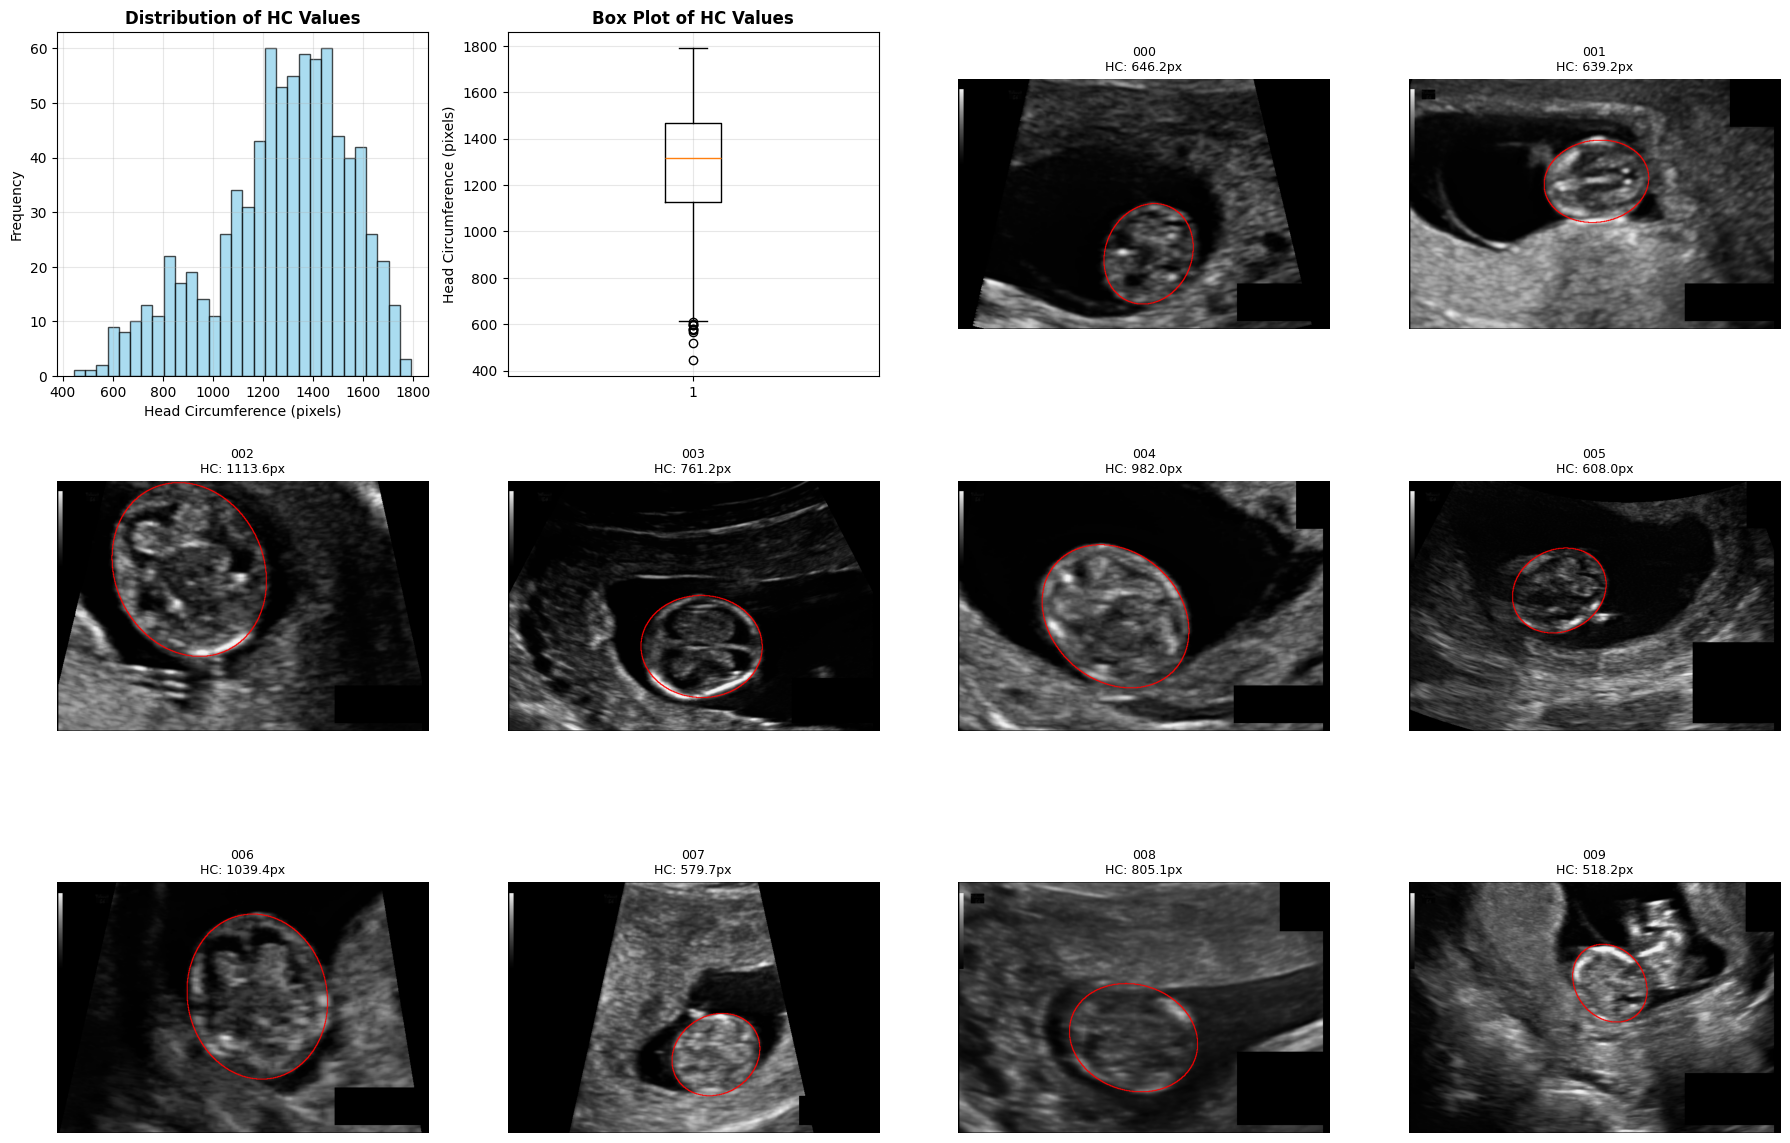


DATA QUALITY
Missing values: 0
Potential outliers (using IQR method): 10
Outlier IDs: ['005', '007', '009', '071', '094', '096', '110', '140', '173', '637']

✓ Saved: outputs/tables/training_data_info.csv


In [6]:
def analyze_and_visualize_dataset(df, train_path):
    """Phân tích và visualize dataset"""
    
    # Thống kê cơ bản
    print("="*60)
    print("DATASET STATISTICS")
    print("="*60)
    print(f"Number of training samples: {len(df)}")
    print(f"\nHead Circumference (pixels):")
    print(f"  Min:  {df['hc_pixels'].min():.2f}")
    print(f"  Max:  {df['hc_pixels'].max():.2f}")
    print(f"  Mean: {df['hc_pixels'].mean():.2f}")
    print(f"  Std:  {df['hc_pixels'].std():.2f}")
    
    # Load một sample image để check dimensions
    sample_img = cv2.imread(df.iloc[0]['image_path'], cv2.IMREAD_GRAYSCALE)
    print(f"\nImage dimensions: {sample_img.shape}")
    print(f"Image dtype: {sample_img.dtype}")
    
    # Visualization
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Histogram of HC values
    ax1 = plt.subplot(3, 4, 1)
    plt.hist(df['hc_pixels'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    plt.xlabel('Head Circumference (pixels)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title('Distribution of HC Values', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Box plot
    ax2 = plt.subplot(3, 4, 2)
    plt.boxplot(df['hc_pixels'], vert=True)
    plt.ylabel('Head Circumference (pixels)', fontsize=10)
    plt.title('Box Plot of HC Values', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Plots 3-12: Sample images with annotations
    samples_to_show = min(10, len(df))
    
    for i in range(samples_to_show):
        row = df.iloc[i]
        
        ax = plt.subplot(3, 4, i+3)
        
        # Load original image
        img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        
        # Load annotation
        annot = cv2.imread(row['annotation_path'], cv2.IMREAD_GRAYSCALE)
        
        # Overlay annotation on original image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        # Make annotation red
        mask = annot > 127
        img_rgb[mask, 0] = 255  # Red channel
        img_rgb[mask, 1] = 0
        img_rgb[mask, 2] = 0
        
        plt.imshow(img_rgb)
        plt.title(f'{row["image_id"]}\nHC: {row["hc_pixels"]:.1f}px', fontsize=9)
        plt.axis('off')
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs('../outputs/figures/', exist_ok=True)
    plt.savefig('../outputs/figures/dataset_exploration.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: outputs/figures/dataset_exploration.png")
    plt.show()
    
    # Additional analysis: Check for outliers
    Q1 = df['hc_pixels'].quantile(0.25)
    Q3 = df['hc_pixels'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['hc_pixels'] < Q1 - 1.5*IQR) | (df['hc_pixels'] > Q3 + 1.5*IQR)]
    
    print(f"\n{'='*60}")
    print(f"DATA QUALITY")
    print(f"{'='*60}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Potential outliers (using IQR method): {len(outliers)}")
    if len(outliers) > 0:
        print(f"Outlier IDs: {outliers['image_id'].tolist()}")

# Run analysis
analyze_and_visualize_dataset(df_train, TRAIN_PATH)

# Save dataframe for later use
df_train.to_csv('../outputs/tables/training_data_info.csv', index=False)
print("\n✓ Saved: outputs/tables/training_data_info.csv")

In [10]:
def load_images_and_labels(df, target_size=(224, 224)):
    """
    Load tất cả images và HC labels từ dataframe
    
    Args:
        df: dataframe chứa image_path và hc_pixels
        target_size: tuple (height, width) for resizing images
    
    Returns:
        X: numpy array of images with uniform size
        y: numpy array of HC values
    """
    images = []
    labels = []
    
    print(f"Loading {len(df)} images...")
    print(f"Resizing all images to {target_size}...")
    
    for idx, row in df.iterrows():
        # Load image
        img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            # Resize image to uniform dimensions
            img_resized = cv2.resize(img, target_size)
            images.append(img_resized)
            labels.append(row['hc_pixels'])
        else:
            print(f"Warning: Cannot load {row['image_id']}")
        
        # Progress indicator
        if (idx + 1) % 50 == 0:
            print(f"  Loaded {idx + 1}/{len(df)} images...")
    
    X = np.array(images)
    y = np.array(labels)
    
    print(f"\n✓ Successfully loaded {len(X)} images")
    print(f"  Image shape: {X[0].shape}")
    
    return X, y

# Load data
X, y = load_images_and_labels(df_train, target_size=(224, 224))

Loading 806 images...
Resizing all images to (224, 224)...
  Loaded 50/806 images...
  Loaded 100/806 images...
  Loaded 150/806 images...
  Loaded 200/806 images...
  Loaded 250/806 images...
  Loaded 300/806 images...
  Loaded 350/806 images...
  Loaded 400/806 images...
  Loaded 450/806 images...
  Loaded 500/806 images...
  Loaded 550/806 images...
  Loaded 600/806 images...
  Loaded 650/806 images...
  Loaded 700/806 images...
  Loaded 750/806 images...
  Loaded 800/806 images...

✓ Successfully loaded 806 images
  Image shape: (224, 224)


In [11]:
from sklearn.model_selection import train_test_split

# Split 1: test 15%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)

# Split 2: train 70%, val 15%  (0.176 * 0.85 ≈ 0.15)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, shuffle=True
)

print("="*60)
print("DATA SPLIT")
print("="*60)
print(f"Train set:      {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nThen label stats (pixels):")
print(f"  Train:      {y_train.mean():.2f} ± {y_train.std():.2f}")
print(f"  Validation: {y_val.mean():.2f} ± {y_val.std():.2f}")
print(f"  Test:       {y_test.mean():.2f} ± {y_test.std():.2f}")

split_info = {
    'total_samples': len(X),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'train_ratio': len(X_train)/len(X),
    'val_ratio': len(X_val)/len(X),
    'test_ratio': len(X_test)/len(X),
    'train_mean_hc': float(y_train.mean()),
    'train_std_hc': float(y_train.std()),
    'val_mean_hc': float(y_val.mean()),
    'val_std_hc': float(y_val.std()),
    'test_mean_hc': float(y_test.mean()),
    'test_std_hc': float(y_test.std()),
}

with open('../outputs/tables/data_split_info.json', 'w') as f:
    json.dump(split_info, f, indent=4)

print("\n✓ Saved: outputs/tables/data_split_info.json")


DATA SPLIT
Train set:      564 images (70.0%)
Validation set: 121 images (15.0%)
Test set:       121 images (15.0%)

Then label stats (pixels):
  Train:      1275.67 ± 265.04
  Validation: 1262.39 ± 277.66
  Test:       1277.12 ± 269.92

✓ Saved: outputs/tables/data_split_info.json


In [12]:
def preprocess_image(image, target_size=(224, 224)):
    """
    Resize and normalize image

    Returns:
        preprocessed image with shape (H, W, 1)
    """
    img = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

print("Preprocessing images...")
X_train_prep = np.array([preprocess_image(img) for img in X_train])
X_val_prep   = np.array([preprocess_image(img) for img in X_val])
X_test_prep  = np.array([preprocess_image(img) for img in X_test])

print(f"\n✓ Preprocessing completed")
print(f"  Train shape: {X_train_prep.shape}")
print(f"  Val shape:   {X_val_prep.shape}")
print(f"  Test shape:  {X_test_prep.shape}")
print(f"  Value range: [{X_train_prep.min():.3f}, {X_train_prep.max():.3f}]")


Preprocessing images...

✓ Preprocessing completed
  Train shape: (564, 224, 224, 1)
  Val shape:   (121, 224, 224, 1)
  Test shape:  (121, 224, 224, 1)
  Value range: [0.000, 0.996]


✓ Saved: outputs/figures/preprocessing_visualization.png


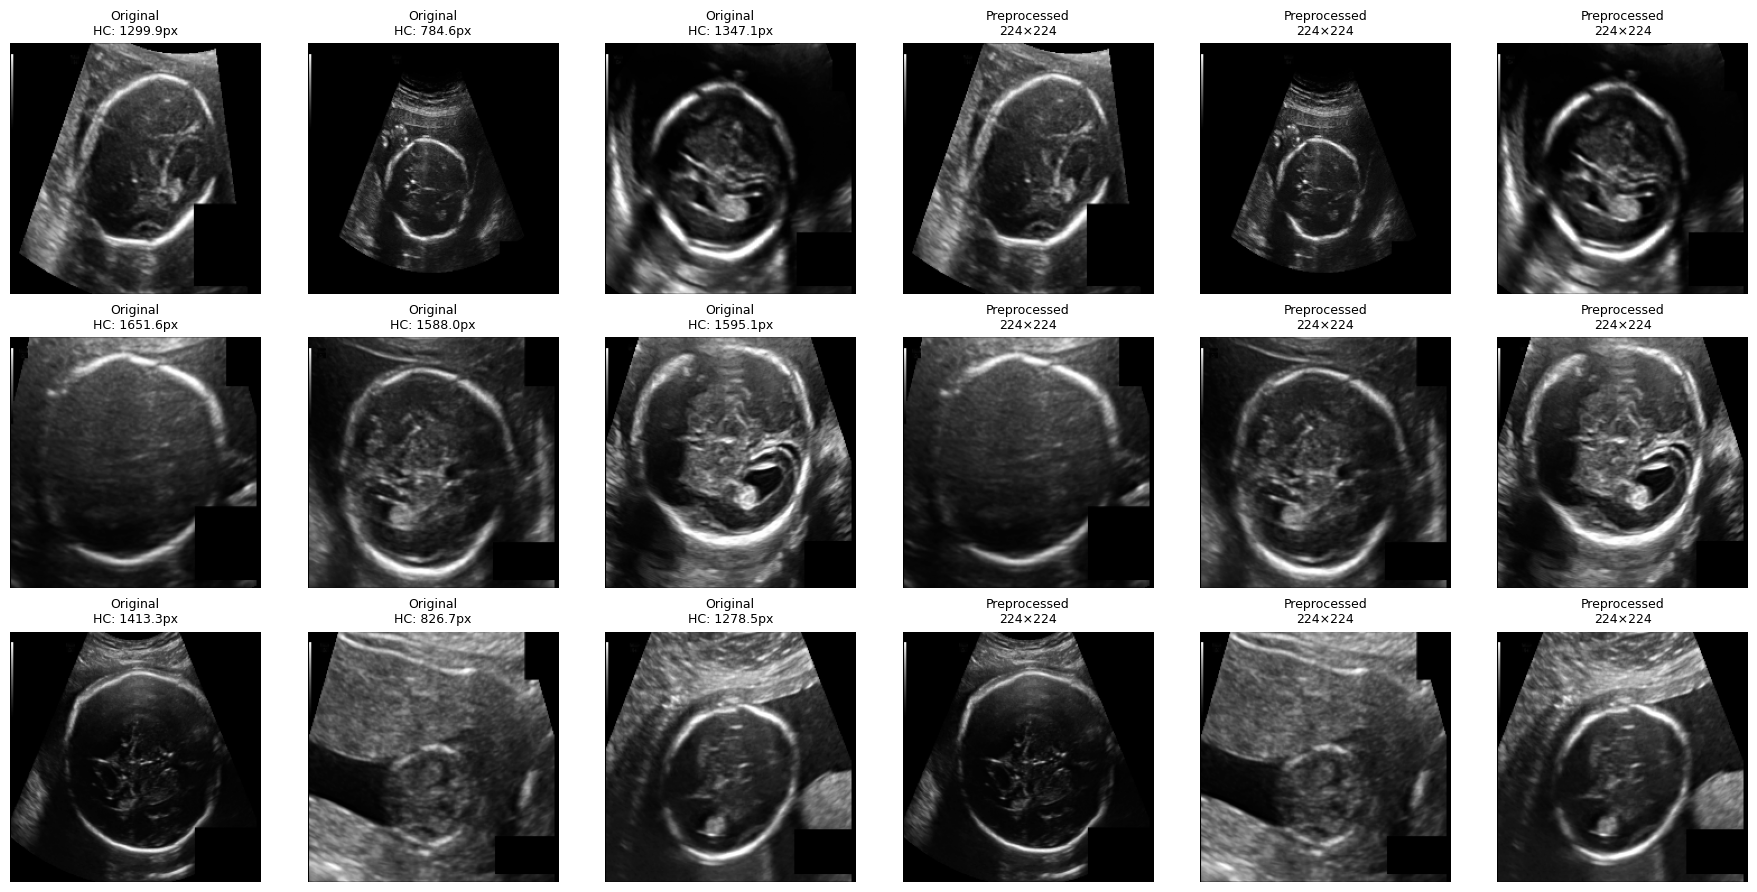

In [13]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i in range(3):
    axes[i, 0].imshow(X_train[i*3], cmap='gray')
    axes[i, 0].set_title(f'Original\nHC: {y_train[i*3]:.1f}px', fontsize=9)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(X_train[i*3+1], cmap='gray')
    axes[i, 1].set_title(f'Original\nHC: {y_train[i*3+1]:.1f}px', fontsize=9)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(X_train[i*3+2], cmap='gray')
    axes[i, 2].set_title(f'Original\nHC: {y_train[i*3+2]:.1f}px', fontsize=9)
    axes[i, 2].axis('off')

    axes[i, 3].imshow(X_train_prep[i*3].squeeze(), cmap='gray')
    axes[i, 3].set_title('Preprocessed\n224×224', fontsize=9)
    axes[i, 3].axis('off')

    axes[i, 4].imshow(X_train_prep[i*3+1].squeeze(), cmap='gray')
    axes[i, 4].set_title('Preprocessed\n224×224', fontsize=9)
    axes[i, 4].axis('off')

    axes[i, 5].imshow(X_train_prep[i*3+2].squeeze(), cmap='gray')
    axes[i, 5].set_title('Preprocessed\n224×224', fontsize=9)
    axes[i, 5].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/preprocessing_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Saved: outputs/figures/preprocessing_visualization.png")
plt.show()


In [14]:
y_train_mean = y_train.mean()
y_train_std  = y_train.std()

y_train_norm = (y_train - y_train_mean) / y_train_std
y_val_norm   = (y_val   - y_train_mean) / y_train_std
y_test_norm  = (y_test  - y_train_mean) / y_train_std

print("="*60)
print("LABEL NORMALIZATION")
print("="*60)
print(f"Original HC range: {y_train.min():.2f} - {y_train.max():.2f} pixels")
print(f"Normalized range:  {y_train_norm.min():.2f} - {y_train_norm.max():.2f}")
print(f"\nNormalization parameters:")
print(f"  Mean: {y_train_mean:.2f}")
print(f"  Std:  {y_train_std:.2f}")

norm_params = {'y_mean': float(y_train_mean), 'y_std': float(y_train_std)}
with open('../outputs/tables/label_normalization_params.json', 'w') as f:
    json.dump(norm_params, f, indent=4)

print("\n✓ Saved: outputs/tables/label_normalization_params.json")
print("NOTE: Train with y_*_norm, but denormalize when evaluating!")


LABEL NORMALIZATION
Original HC range: 444.56 - 1791.88 pixels
Normalized range:  -3.14 - 1.95

Normalization parameters:
  Mean: 1275.67
  Std:  265.04

✓ Saved: outputs/tables/label_normalization_params.json
NOTE: Train with y_*_norm, but denormalize when evaluating!


✓ Saved: outputs/figures/data_augmentation.png


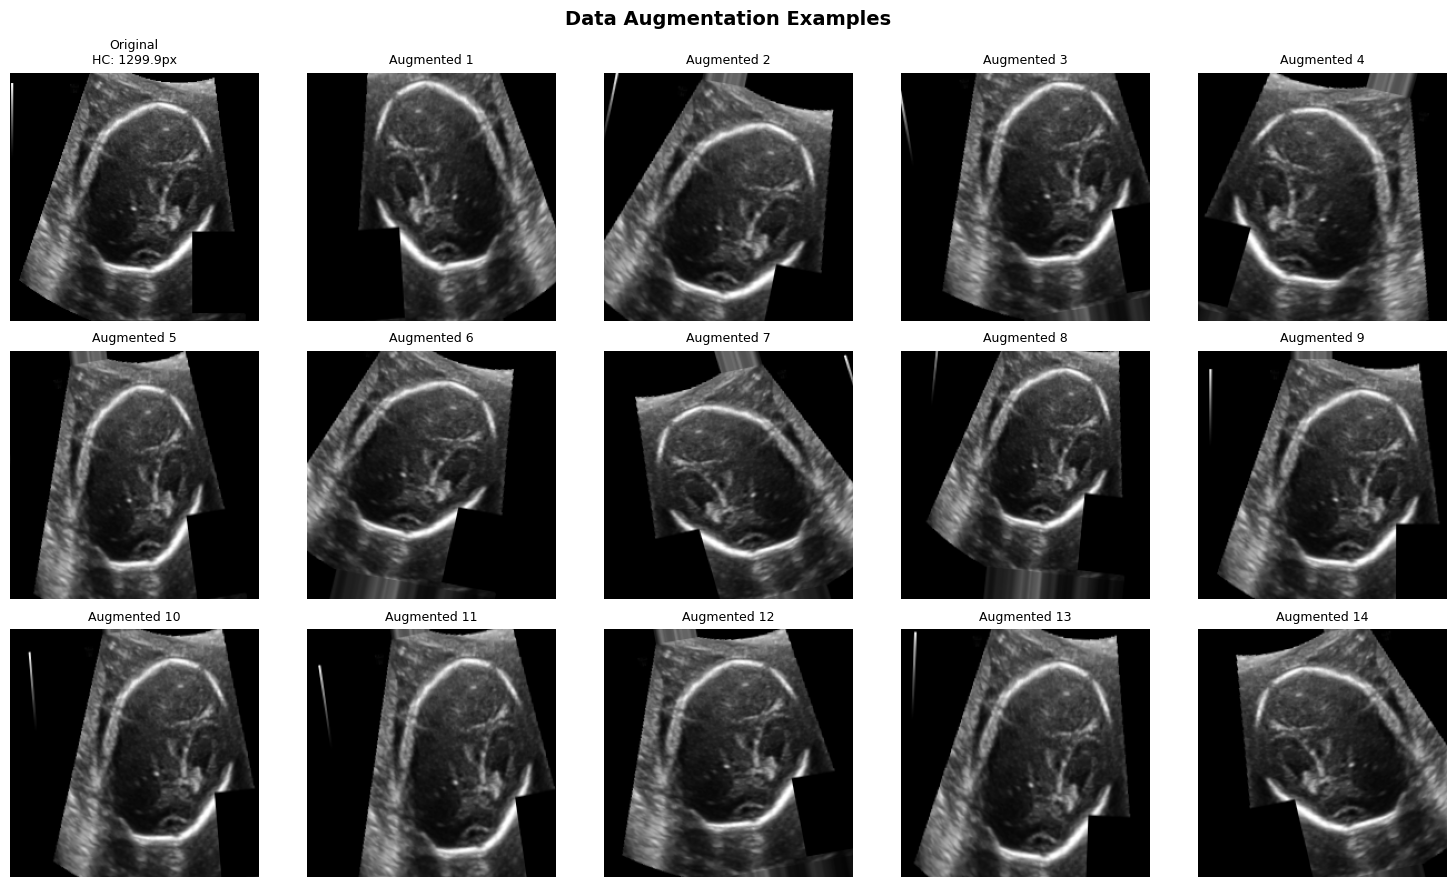


✓ Data preprocessing completed!
  Training:   564 samples
  Validation: 121 samples
  Test:       121 samples


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_prep)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

sample_img = X_train_prep[0:1]
sample_label = y_train[0]

axes[0, 0].imshow(sample_img[0].squeeze(), cmap='gray')
axes[0, 0].set_title(f'Original\nHC: {sample_label:.1f}px', fontsize=9)
axes[0, 0].axis('off')

aug_iter = datagen.flow(sample_img, batch_size=1, seed=42)

for i in range(14):
    aug_img = next(aug_iter)[0]
    row = (i + 1) // 5
    col = (i + 1) % 5
    axes[row, col].imshow(aug_img.squeeze(), cmap='gray')
    axes[row, col].set_title(f'Augmented {i+1}', fontsize=9)
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/data_augmentation.png', dpi=300, bbox_inches='tight')
print("✓ Saved: outputs/figures/data_augmentation.png")
plt.show()

print("\n✓ Data preprocessing completed!")
print(f"  Training:   {len(X_train_prep)} samples")
print(f"  Validation: {len(X_val_prep)} samples")
print(f"  Test:       {len(X_test_prep)} samples")


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(224, 224, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1)  # regression
    ])

    model.compile(
        optimizer='adam',
        loss='mean_absolute_error',
        metrics=['mae', 'mse']
    )
    return model

model = build_cnn_model()
model.summary()


/opt/miniconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,277,121 (84.98 MB)

 Trainable params: 22,277,121 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

checkpoint = ModelCheckpoint(
    '../outputs/models/best_model.h5',
    monitor='val_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_mae',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

csv_logger = CSVLogger('../outputs/tables/training_history.csv', append=False)

print("Starting training...")
print("Note: Training with normalized labels for better stability")

history = model.fit(
    X_train_prep, y_train_norm,
    validation_data=(X_val_prep, y_val_norm),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr, csv_logger],
    verbose=1
)

print("\n✓ Training completed!")
print("✓ Best model saved: outputs/models/best_model.h5")
print("✓ Training history saved: outputs/tables/training_history.csv")

best_val_mae_norm = min(history.history['val_mae'])
best_val_mae_pixels = best_val_mae_norm * y_train_std

print(f"\nBest Validation MAE:")
print(f"  Normalized scale: {best_val_mae_norm:.4f}")
print(f"  Original scale (pixels): {best_val_mae_pixels:.4f}")


Starting training...
Note: Training with normalized labels for better stability
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 1.3166 - mae: 1.3166 - mse: 4.2674
Epoch 1: val_mae improved from None to 0.66674, saving model to ../outputs/models/best_model.h5



Epoch 1: finished saving model to ../outputs/models/best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - loss: 0.9993 - mae: 0.9993 - mse: 2.3470 - val_loss: 0.6667 - val_mae: 0.6667 - val_mse: 0.7583 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 0.6208 - mae: 0.6208 - mse: 0.6872
Epoch 2: val_mae improved from 0.66674 to 0.54239, saving model to ../outputs/models/best_model.h5



Epoch 2: finished saving model to ../outputs/models/best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - loss: 0.5791 - mae: 0.5791 - mse: 0.6418 - val_loss: 0.5424 - val_mae: 0.5424 - val_mse: 0.4943 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 0.5458 - mae: 0.5458 - mse: 0.5388
Epoch 3: val_mae improved from 0.54239 to 0.48503, saving model to ../outputs/models/best_model.h5



Epoch 3: finished saving model to ../outputs/models/best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 573ms/step - loss: 0.5034 - mae: 0.5034 - mse: 0.4977 - val_loss: 0.4850 - val_mae: 0.4850 - val_mse: 0.4599 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 0.4516 - mae: 0.4516 - mse: 0.4072
Epoch 4: val_mae improved from 0.48503 to 0.37412, saving model to ../outputs/models/best_model.h5



Epoch 4: finished saving model to ../outputs/models/best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 579ms/step - loss: 0.4360 - mae: 0.4360 - mse: 0.3814 - val_loss: 0.3741 - val_mae: 0.3741 - val_mse: 0.2994 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 0.4070 - mae: 0.4070 - mse: 0.3186
Epoch 5: val_mae did not improve from 0.37412
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - loss: 0.3859 - mae: 0.3859 - mse: 0.3070 - val_loss: 0.3947 - val_mae: 0.3947 - val_mse: 0.3049 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 0.3502 - mae: 0.3502 - mse: 0.2436
Epoch 6: val_mae improved from 0.37412 to 0.34822, saving model to ../outputs/models/best_model.h5



Epoch 6: finished saving model to ../outputs/models/best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 569ms/step - loss: 0.3423 - mae: 0.3423 - mse: 0.2482 - val_loss: 0.3482 - val_mae: 0.3482 - val_mse: 0.2994 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 0.3159 - mae: 0.3159 - mse: 0.1961
Epoch 7: val_mae did not improve from 0.34822
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 550ms/step - loss: 0.3230 - mae: 0.3230 - mse: 0.2115 - val_loss: 0.3545 - val_mae: 0.3545 - val_mse: 0.2931 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 0.3022 - mae: 0.3022 - mse: 0.2063
Epoch 8: val_mae did not improve from 0.34822
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 551ms/step - loss: 0.2916 - mae: 0.2916 - mse: 0.1908 - val_loss: 0.3921 - val_mae: 0.3921 - val_mse: 0.2912 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.3069 - mae: 0.3069 - mse: 0.1891
Epoch 9: val_mae improved from 0.34822 to 0.33574, saving mod


Epoch 9: finished saving model to ../outputs/models/best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - loss: 0.2951 - mae: 0.2951 - mse: 0.1757 - val_loss: 0.3357 - val_mae: 0.3357 - val_mse: 0.2511 - learning_rate: 0.0010
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 0.2510 - mae: 0.2510 - mse: 0.1318
Epoch 10: val_mae did not improve from 0.33574
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - loss: 0.2698 - mae: 0.2698 - mse: 0.1528 - val_loss: 0.3682 - val_mae: 0.3682 - val_mse: 0.2649 - learning_rate: 0.0010
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 0.2427 - mae: 0.2427 - mse: 0.1192
Epoch 11: val_mae did not improve from 0.33574
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - loss: 0.2510 - mae: 0.2510 - mse: 0.1303 - val_loss: 0.3766 - val_mae: 0.3766 - val_mse: 0.2891 - learning_rate: 0.0010
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 0.2783 - mae: 0.2783 - mse: 0.1689
Epoch 12: val_mae did not improve from 0.33574
18/18 ━━━


Epoch 14: finished saving model to ../outputs/models/best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - loss: 0.2328 - mae: 0.2328 - mse: 0.1200 - val_loss: 0.3137 - val_mae: 0.3137 - val_mse: 0.2455 - learning_rate: 0.0010
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 0.2647 - mae: 0.2647 - mse: 0.1455
Epoch 15: val_mae did not improve from 0.31366
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - loss: 0.2347 - mae: 0.2347 - mse: 0.1072 - val_loss: 0.3468 - val_mae: 0.3468 - val_mse: 0.2604 - learning_rate: 0.0010
Epoch 16/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.2220 - mae: 0.2220 - mse: 0.1033
Epoch 16: val_mae did not improve from 0.31366
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - loss: 0.2167 - mae: 0.2167 - mse: 0.0976 - val_loss: 0.3788 - val_mae: 0.3788 - val_mse: 0.2777 - learning_rate: 0.0010
Epoch 17/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.2266 - mae: 0.2266 - mse: 0.1084
Epoch 17: val_mae did not improve from 0.31366
18/18 ━━━

✓ Saved: ../outputs/figures/training_history.png


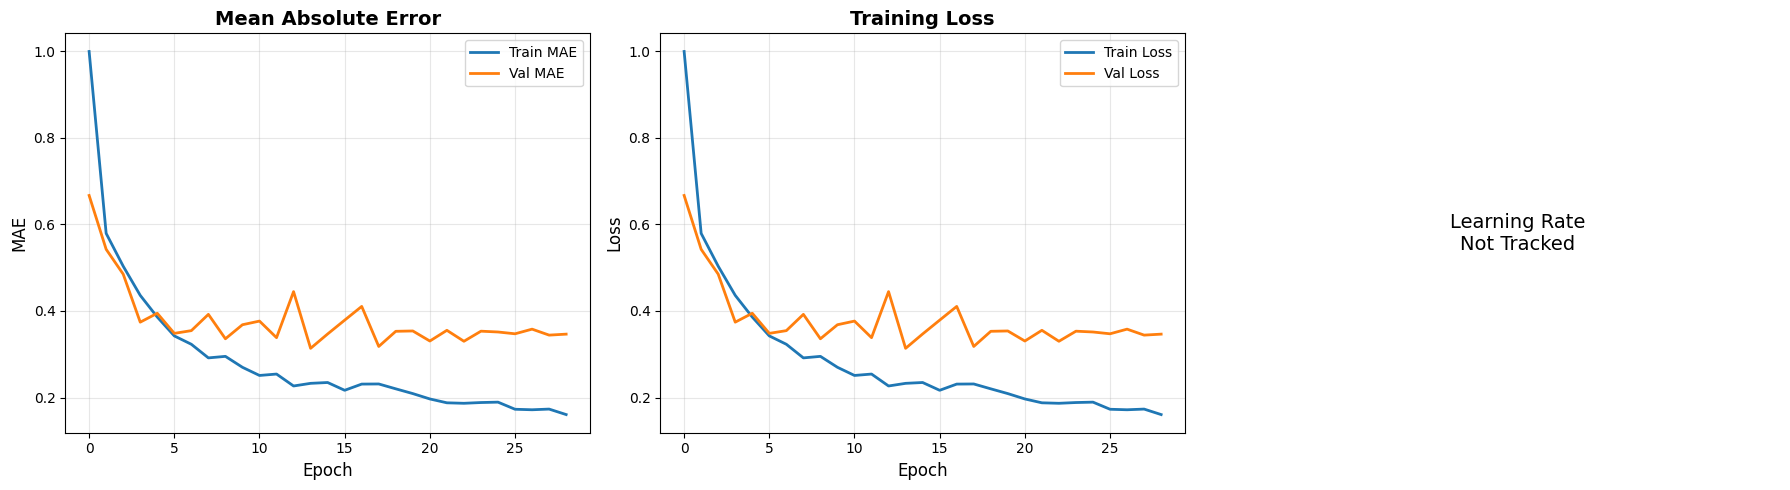


Best Epoch: 14
Best Validation MAE (normalized): 0.3137


In [18]:
def plot_training_history(history, save_path='../outputs/figures/training_history.png'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[0].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MAE', fontsize=12)
    axes[0].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    if 'lr' in history.history:
        axes[2].plot(history.history['lr'], linewidth=2)
        axes[2].set_xlabel('Epoch', fontsize=12)
        axes[2].set_ylabel('Learning Rate', fontsize=12)
        axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[2].set_yscale('log')
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'Learning Rate\nNot Tracked',
                     ha='center', va='center', fontsize=14)
        axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}")
    plt.show()

    best_epoch = np.argmin(history.history['val_mae'])
    best_val_mae = history.history['val_mae'][best_epoch]
    print(f"\nBest Epoch: {best_epoch + 1}")
    print(f"Best Validation MAE (normalized): {best_val_mae:.4f}")

plot_training_history(history)


In [19]:
from tensorflow.keras.models import load_model

best_model = load_model('../outputs/models/best_model.h5')

y_pred_train_norm = best_model.predict(X_train_prep, verbose=0).flatten()
y_pred_val_norm   = best_model.predict(X_val_prep,   verbose=0).flatten()
y_pred_test_norm  = best_model.predict(X_test_prep,  verbose=0).flatten()

# Denormalize back to pixels
y_pred_train = y_pred_train_norm * y_train_std + y_train_mean
y_pred_val   = y_pred_val_norm   * y_train_std + y_train_mean
y_pred_test  = y_pred_test_norm  * y_train_std + y_train_mean

print("✓ Predictions completed and denormalized")
print(f"  Prediction range: {y_pred_test.min():.2f} - {y_pred_test.max():.2f} pixels")
print(f"  True range:       {y_test.min():.2f} - {y_test.max():.2f} pixels")


✓ Predictions completed and denormalized
  Prediction range: 736.37 - 1748.58 pixels
  True range:       565.58 - 1725.85 pixels


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} SET METRICS")
    print(f"{'='*50}")
    print(f"MAE:  {mae:.4f} pixels")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f} pixels")
    print(f"R²:   {r2:.4f}")

    return {'dataset': dataset_name, 'mae': float(mae), 'mse': float(mse), 'rmse': float(rmse), 'r2': float(r2)}

metrics_train = calculate_metrics(y_train, y_pred_train, "Train")
metrics_val   = calculate_metrics(y_val,   y_pred_val,   "Validation")
metrics_test  = calculate_metrics(y_test,  y_pred_test,  "Test")

metrics_df = pd.DataFrame([metrics_train, metrics_val, metrics_test])
metrics_df.to_csv('../outputs/tables/evaluation_metrics.csv', index=False)
print("\n✓ Saved: outputs/tables/evaluation_metrics.csv")
display(metrics_df)



TRAIN SET METRICS
MAE:  36.2442 pixels
MSE:  3066.4031
RMSE: 55.3751 pixels
R²:   0.9563

VALIDATION SET METRICS
MAE:  83.1316 pixels
MSE:  17246.4131
RMSE: 131.3256 pixels
R²:   0.7763

TEST SET METRICS
MAE:  81.0071 pixels
MSE:  16974.0568
RMSE: 130.2845 pixels
R²:   0.7670

✓ Saved: outputs/tables/evaluation_metrics.csv


,dataset,mae,mse,rmse,r2
0,Train,36.244169,3066.403076,55.375112,0.956347
1,Validation,83.131576,17246.413124,131.325600,0.776297
2,Test,81.007073,16974.056810,130.284523,0.767020


✓ Saved: ../outputs/figures/train_predictions.png


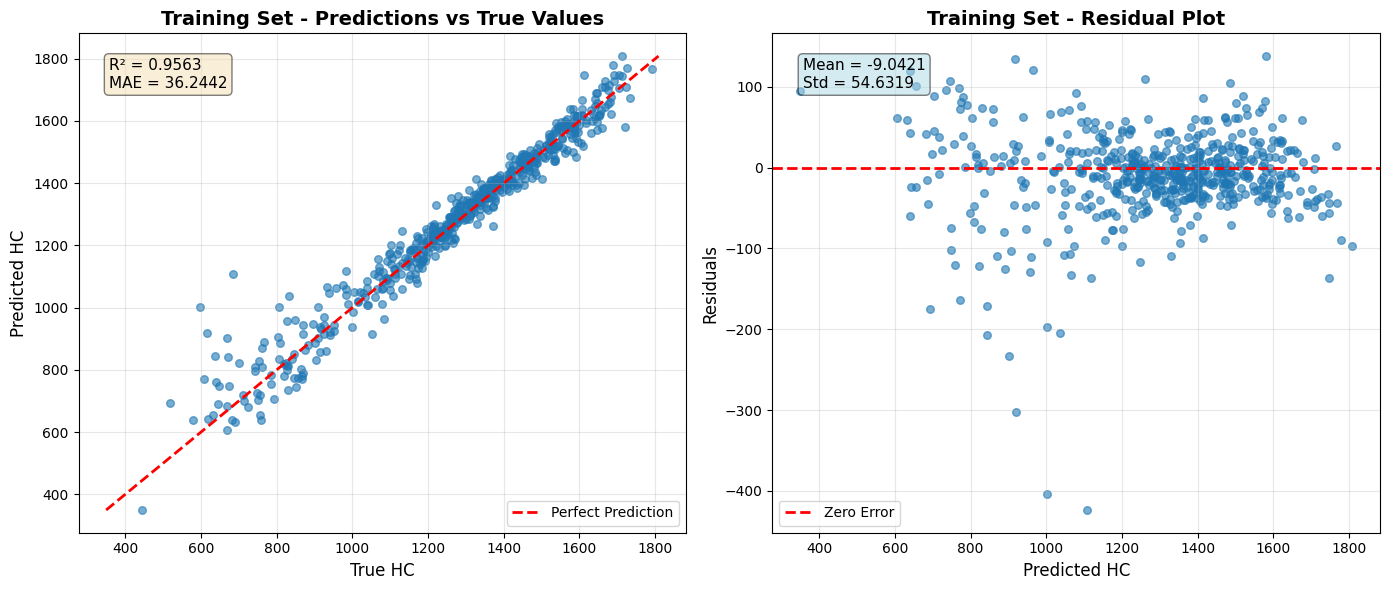

✓ Saved: ../outputs/figures/val_predictions.png


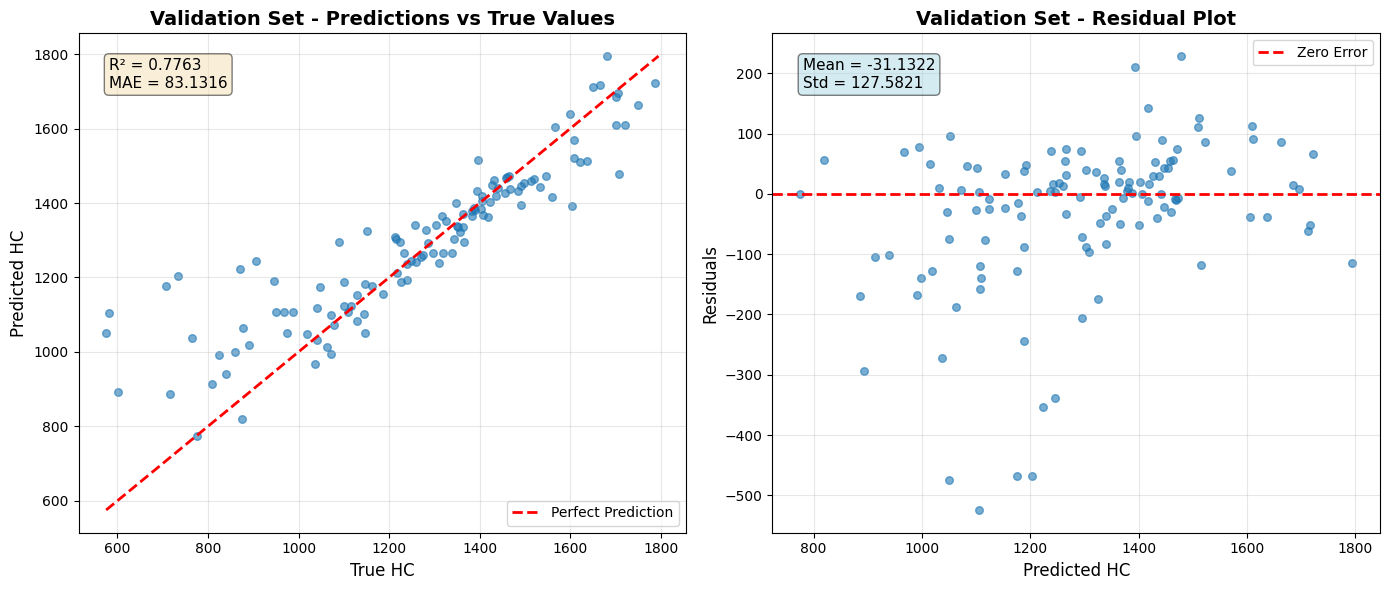

✓ Saved: ../outputs/figures/test_predictions.png


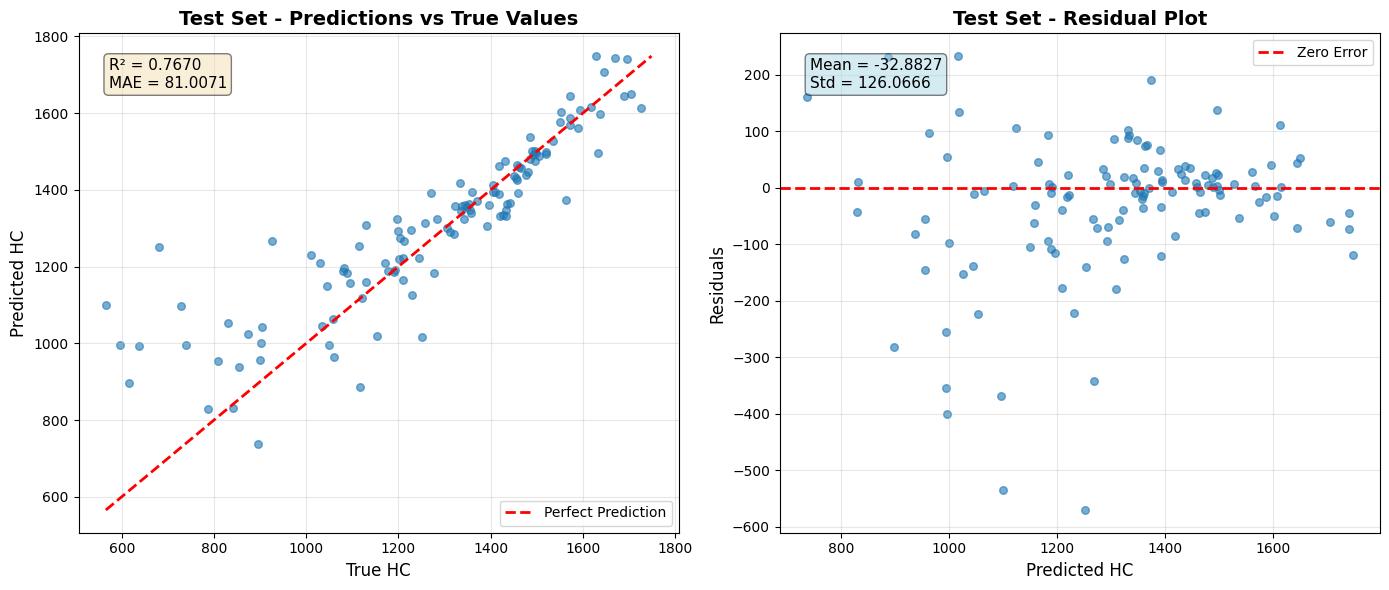

In [21]:
def plot_predictions(y_true, y_pred, dataset_name, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].scatter(y_true, y_pred, alpha=0.6, s=30)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    axes[0].set_xlabel('True HC', fontsize=12)
    axes[0].set_ylabel('Predicted HC', fontsize=12)
    axes[0].set_title(f'{dataset_name} - Predictions vs True Values', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    axes[0].text(0.05, 0.95, f'R² = {r2:.4f}\nMAE = {mae:.4f}',
                 transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, s=30)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
    axes[1].set_xlabel('Predicted HC', fontsize=12)
    axes[1].set_ylabel('Residuals', fontsize=12)
    axes[1].set_title(f'{dataset_name} - Residual Plot', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    axes[1].text(0.05, 0.95, f'Mean = {residuals.mean():.4f}\nStd = {residuals.std():.4f}',
                 transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}")
    plt.show()

plot_predictions(y_train, y_pred_train, "Training Set",   '../outputs/figures/train_predictions.png')
plot_predictions(y_val,   y_pred_val,   "Validation Set", '../outputs/figures/val_predictions.png')
plot_predictions(y_test,  y_pred_test,  "Test Set",       '../outputs/figures/test_predictions.png')



TOP 10 WORST PREDICTIONS
Index    True HC      Pred HC      Error     
--------------------------------------------------
35       681.25       1252.04      570.79    
119      565.58       1100.32      534.74    
68       595.67       996.01       400.34    
57       727.74       1096.86      369.12    
67       638.37       993.50       355.13    
75       925.31       1267.89      342.58    
38       615.19       897.68       282.49    
21       739.19       994.50       255.32    
29       1250.00      1017.08      232.92    
24       1116.86      885.89       230.97    

ERROR STATISTICS
Mean Absolute Error: 81.0071
Std of Errors: 102.0388
Max Error: 570.7864
Predictions with error > 5.0: 111
Percentage: 91.74%

✓ Saved: outputs/figures/error_distribution.png


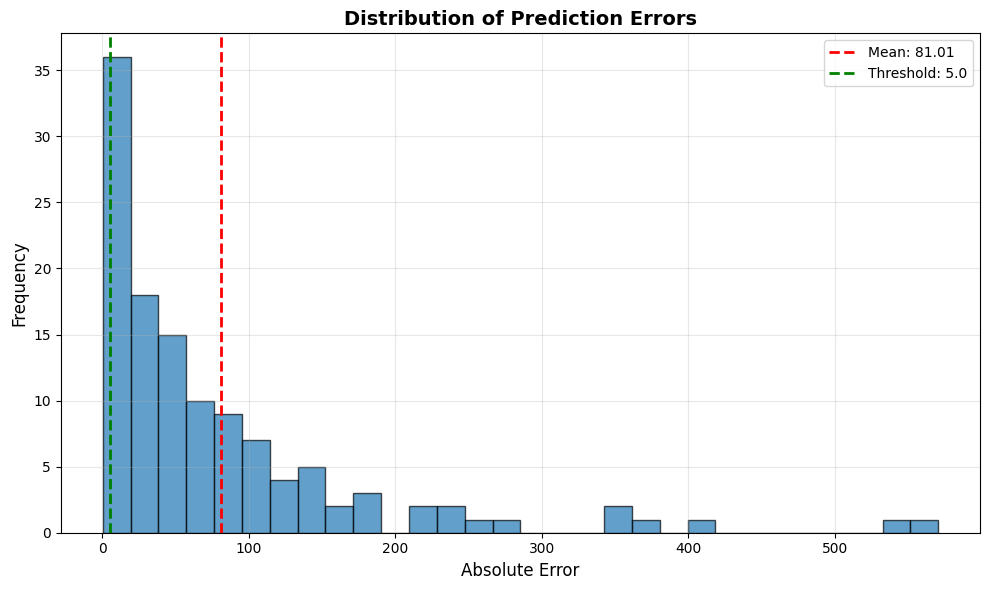

In [22]:
def analyze_errors(y_true, y_pred, threshold=5.0):
    errors = np.abs(y_true - y_pred)

    worst_idx = np.argsort(errors)[-10:][::-1]

    print(f"\n{'='*50}")
    print("TOP 10 WORST PREDICTIONS")
    print(f"{'='*50}")
    print(f"{'Index':<8} {'True HC':<12} {'Pred HC':<12} {'Error':<10}")
    print("-" * 50)

    for idx in worst_idx:
        print(f"{idx:<8} {y_true[idx]:<12.2f} {y_pred[idx]:<12.2f} {errors[idx]:<10.2f}")

    print(f"\n{'='*50}")
    print("ERROR STATISTICS")
    print(f"{'='*50}")
    print(f"Mean Absolute Error: {errors.mean():.4f}")
    print(f"Std of Errors: {errors.std():.4f}")
    print(f"Max Error: {errors.max():.4f}")
    print(f"Predictions with error > {threshold}: {(errors > threshold).sum()}")
    print(f"Percentage: {(errors > threshold).sum() / len(errors) * 100:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(errors.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
    plt.axvline(threshold, color='g', linestyle='--', linewidth=2, label=f'Threshold: {threshold}')
    plt.xlabel('Absolute Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/error_distribution.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: outputs/figures/error_distribution.png")
    plt.show()

analyze_errors(y_test, y_pred_test, threshold=5.0)


In [23]:
# Các hyperparameters cần experiment
hyperparameters_grid = {
    'learning_rate': [0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'architecture': ['simple_cnn', 'deep_cnn']
}

print("Hyperparameter Grid:")
for key, values in hyperparameters_grid.items():
    print(f"  {key}: {values}")

Hyperparameter Grid:
  learning_rate: [0.001, 0.0001, 1e-05]
  batch_size: [16, 32, 64]
  dropout_rate: [0.3, 0.5, 0.7]
  optimizer: ['adam', 'sgd', 'rmsprop']
  architecture: ['simple_cnn', 'deep_cnn']


In [25]:
def train_with_hyperparams(X_train, y_train, X_val, y_val, 
                          lr=0.001, batch_size=32, dropout=0.5, 
                          optimizer='adam', architecture='simple_cnn'):
    """
    Train model với hyperparameters cụ thể
    Returns: val_mae, test_mae, training_time
    """
    import time
    
    # Build model dựa trên architecture
    if architecture == 'simple_cnn':
        model = build_simple_cnn(dropout_rate=dropout)
    elif architecture == 'deep_cnn':
        model = build_deep_cnn(dropout_rate=dropout)
    
    # Compile với optimizer và learning rate
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
    
    model.compile(optimizer=opt, loss='mae', metrics=['mae'])
    
    # Callbacks (chỉ early stopping)
    early_stop = EarlyStopping(monitor='val_mae', patience=10, 
                               restore_best_weights=True, verbose=0)
    
    # Training
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Giảm epochs cho experiment nhanh
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )
    training_time = time.time() - start_time
    
    # Get best validation MAE
    val_mae = min(history.history['val_mae'])
    
    return val_mae, training_time, model

def build_simple_cnn(dropout_rate=0.5):
    """Simple CNN architecture"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
    return model

def build_deep_cnn(dropout_rate=0.5):
    """Deeper CNN architecture"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
    return model

# Danh sách experiments
experiments = [
    # Experiment với learning rates
    {'lr': 0.001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'},
    {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'},
    {'lr': 0.00001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'},
    
    # Experiment với batch sizes
    {'lr': 0.0001, 'batch_size': 16, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'},
    {'lr': 0.0001, 'batch_size': 64, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'},
    
    # Experiment với dropout rates
    {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.3, 'optimizer': 'adam', 'architecture': 'simple_cnn'},
    {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.7, 'optimizer': 'adam', 'architecture': 'simple_cnn'},
    
    # Experiment với optimizers
    {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'sgd', 'architecture': 'simple_cnn'},
    {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'rmsprop', 'architecture': 'simple_cnn'},
    
    # Experiment với architectures
    {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'deep_cnn'},
]

# Run experiments và lưu kết quả
results = []

print("Running experiments...")
print(f"Total experiments: {len(experiments)}")
print("="*70)

for i, exp in enumerate(experiments, 1):
    print(f"\nExperiment {i}/{len(experiments)}")
    print(f"Config: {exp}")
    
    val_mae, train_time, _ = train_with_hyperparams(
        X_train_prep, y_train, X_val_prep, y_val, **exp
    )
    
    result = {
        'experiment_id': i,
        'learning_rate': exp['lr'],
        'batch_size': exp['batch_size'],
        'dropout_rate': exp['dropout'],
        'optimizer': exp['optimizer'],
        'architecture': exp['architecture'],
        'val_mae': val_mae,
        'training_time_sec': train_time
    }
    results.append(result)
    
    print(f"  → Val MAE: {val_mae:.4f} mm")
    print(f"  → Training time: {train_time:.1f}s")

print("\n" + "="*70)
print("✓ All experiments completed!")

Running experiments...
Total experiments: 10

Experiment 1/10
Config: {'lr': 0.001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'}


/opt/miniconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  → Val MAE: 120.8008 mm
  → Training time: 247.3s

Experiment 2/10
Config: {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'}
  → Val MAE: 141.6981 mm
  → Training time: 1375.2s

Experiment 3/10
Config: {'lr': 1e-05, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'}
  → Val MAE: 252.9757 mm
  → Training time: 27567.9s

Experiment 4/10
Config: {'lr': 0.0001, 'batch_size': 16, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'}
  → Val MAE: 128.9553 mm
  → Training time: 9418.3s

Experiment 5/10
Config: {'lr': 0.0001, 'batch_size': 64, 'dropout': 0.5, 'optimizer': 'adam', 'architecture': 'simple_cnn'}
  → Val MAE: 179.1525 mm
  → Training time: 429.4s

Experiment 6/10
Config: {'lr': 0.0001, 'batch_size': 32, 'dropout': 0.3, 'optimizer': 'adam', 'architecture': 'simple_cnn'}
  → Val MAE: 134.3752 mm
  → Training time: 419.1s

Experiment 7/10
Config: {'lr': 0.0001, 'batch_size': 32, 'dropout


✓ Đã lưu: outputs/tables/hyperparameter_experiments.csv

TOP 5 BEST CONFIGURATIONS
 experiment_id  learning_rate  batch_size  dropout_rate optimizer architecture    val_mae  training_time_sec
             1         0.0010          32           0.5      adam   simple_cnn 120.800797         247.271494
             4         0.0001          16           0.5      adam   simple_cnn 128.955322        9418.301057
             8         0.0001          32           0.5       sgd   simple_cnn 129.541260         316.908092
            10         0.0001          32           0.5      adam     deep_cnn 133.067322         534.394595
             6         0.0001          32           0.3      adam   simple_cnn 134.375153         419.079918
✓ Đã lưu: outputs/figures/hyperparameter_effects.png


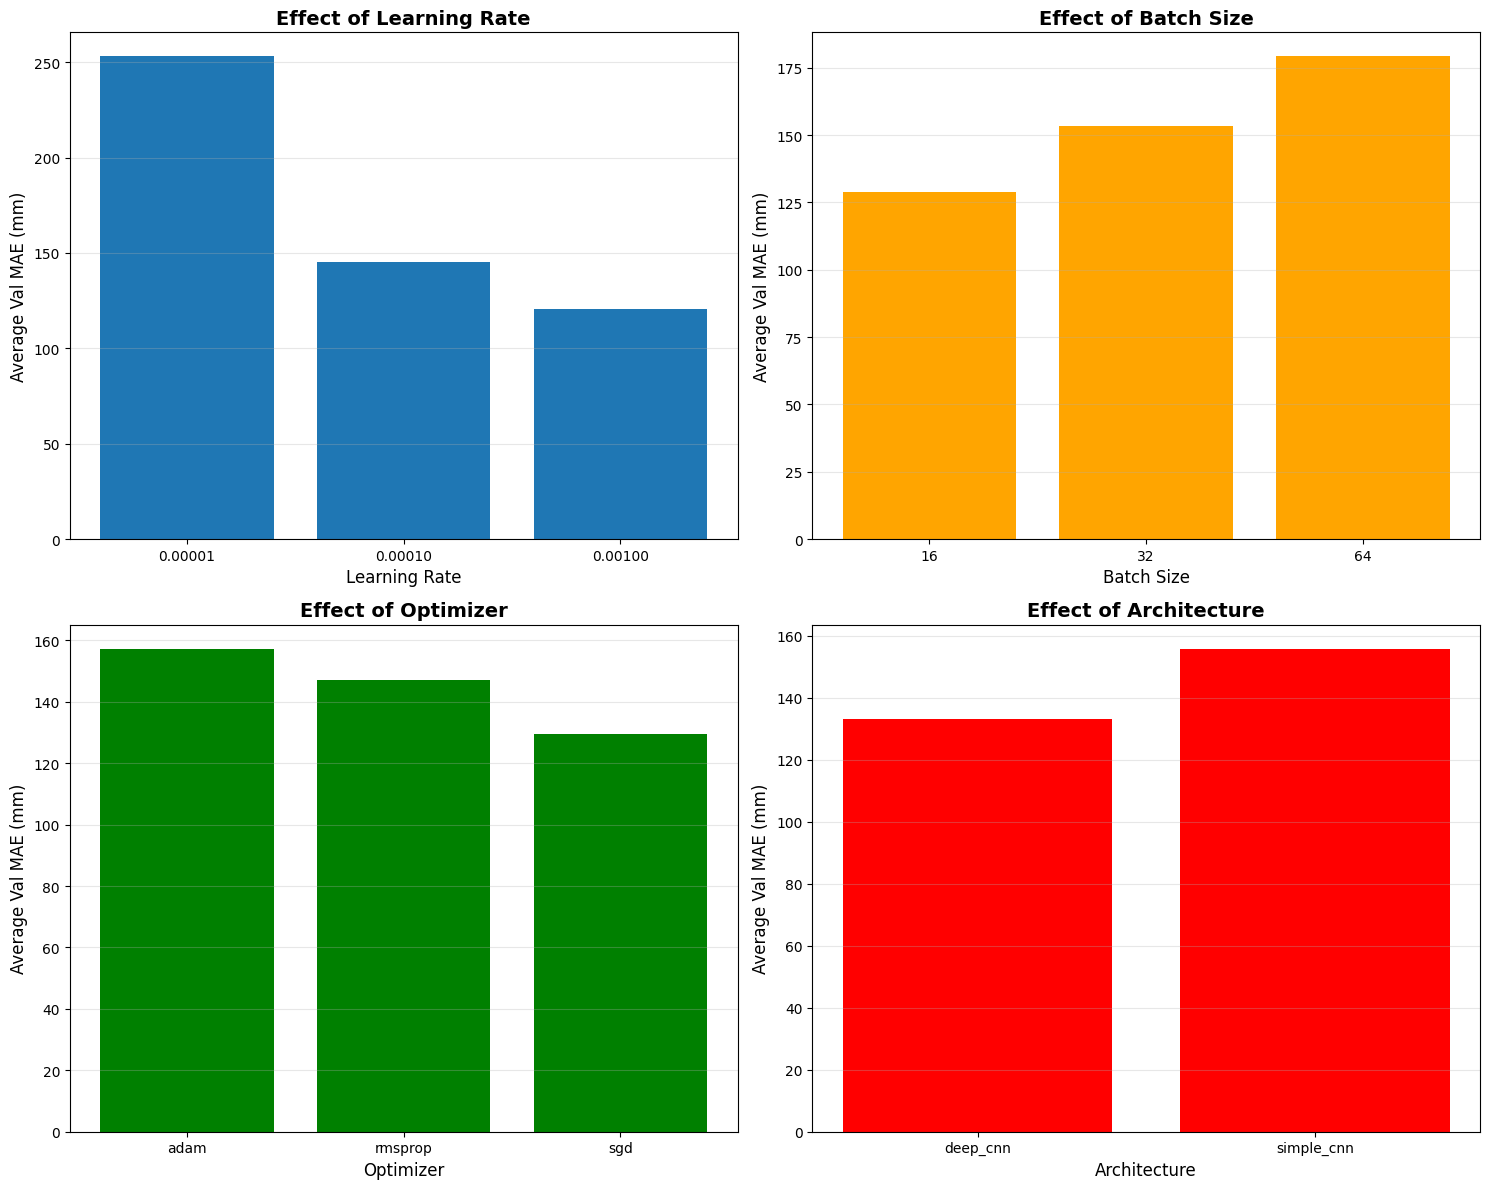

✓ Đã lưu: outputs/figures/hyperparameter_heatmap.png


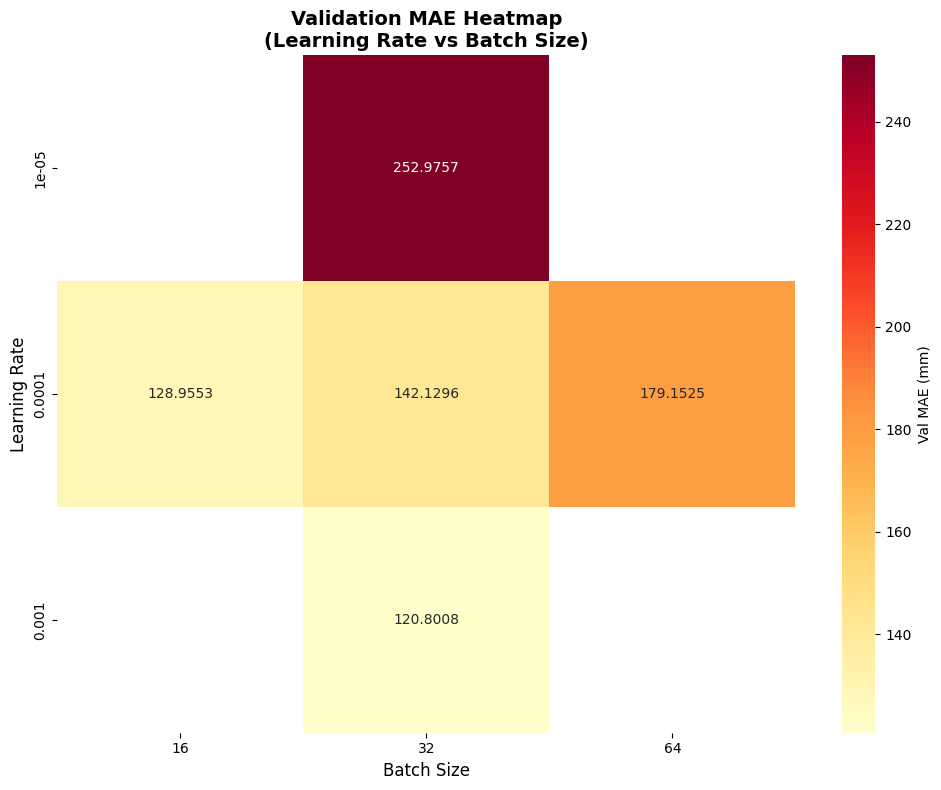

In [26]:
# Lưu kết quả thành CSV
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_mae')
results_df.to_csv('../outputs/tables/hyperparameter_experiments.csv', index=False)
print("\n✓ Đã lưu: outputs/tables/hyperparameter_experiments.csv")

# In top 5 configurations
print("\n" + "="*70)
print("TOP 5 BEST CONFIGURATIONS")
print("="*70)
print(results_df.head(5).to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Val MAE by Learning Rate
lr_groups = results_df.groupby('learning_rate')['val_mae'].mean()
axes[0, 0].bar(range(len(lr_groups)), lr_groups.values)
axes[0, 0].set_xticks(range(len(lr_groups)))
axes[0, 0].set_xticklabels([f'{lr:.5f}' for lr in lr_groups.index])
axes[0, 0].set_xlabel('Learning Rate', fontsize=12)
axes[0, 0].set_ylabel('Average Val MAE (mm)', fontsize=12)
axes[0, 0].set_title('Effect of Learning Rate', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Val MAE by Batch Size
bs_groups = results_df.groupby('batch_size')['val_mae'].mean()
axes[0, 1].bar(range(len(bs_groups)), bs_groups.values, color='orange')
axes[0, 1].set_xticks(range(len(bs_groups)))
axes[0, 1].set_xticklabels(bs_groups.index)
axes[0, 1].set_xlabel('Batch Size', fontsize=12)
axes[0, 1].set_ylabel('Average Val MAE (mm)', fontsize=12)
axes[0, 1].set_title('Effect of Batch Size', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Val MAE by Optimizer
opt_groups = results_df.groupby('optimizer')['val_mae'].mean()
axes[1, 0].bar(range(len(opt_groups)), opt_groups.values, color='green')
axes[1, 0].set_xticks(range(len(opt_groups)))
axes[1, 0].set_xticklabels(opt_groups.index)
axes[1, 0].set_xlabel('Optimizer', fontsize=12)
axes[1, 0].set_ylabel('Average Val MAE (mm)', fontsize=12)
axes[1, 0].set_title('Effect of Optimizer', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Val MAE by Architecture
arch_groups = results_df.groupby('architecture')['val_mae'].mean()
axes[1, 1].bar(range(len(arch_groups)), arch_groups.values, color='red')
axes[1, 1].set_xticks(range(len(arch_groups)))
axes[1, 1].set_xticklabels(arch_groups.index)
axes[1, 1].set_xlabel('Architecture', fontsize=12)
axes[1, 1].set_ylabel('Average Val MAE (mm)', fontsize=12)
axes[1, 1].set_title('Effect of Architecture', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/hyperparameter_effects.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: outputs/figures/hyperparameter_effects.png")
plt.show()

# Heatmap cho learning rate vs batch size
pivot_table = results_df.pivot_table(
    values='val_mae', 
    index='learning_rate', 
    columns='batch_size', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Val MAE (mm)'})
plt.title('Validation MAE Heatmap\n(Learning Rate vs Batch Size)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Batch Size', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/hyperparameter_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: outputs/figures/hyperparameter_heatmap.png")
plt.show()